## Zadání úlohy:

V této úloze použijeme PINN pro model situace nahřívání desky v jednom bodě (například pomocí laseru):

$$\begin{gather*}
    \frac{\partial u(x,\,y,\,t)}{\partial t} = \alpha^2 \cdot \Delta u(x,\,y,\,t) + h(x, y, t), \quad t\in[0, t_0]\\
    \frac{\partial u}{\partial n} = 0 \quad \text{ na } \partial \Omega
\end{gather*}$$

kde $\Omega = \{ (x, y) \in \mathbb{R}^2: |x| \leq 1 \land |y| \leq 1\}$, a
$$\begin{equation*}
    h(x, y, t) := 5 \exp{-100 * (x^2 + y^2)}
\end{equation*}$$

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# prvotni import

from typing import List
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys
from numpy import pi
import matplotlib.pyplot as plt
sys.path.append('..')

In [56]:
# vlastni import
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
import src.models.mlp_model as mm

In [57]:
# volba device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# definice ulohy
ALPHA = 114e-4  # diffusivity constant
A = 100
C = 5
T_0 = 10.0
l_bounds = [-1.0, -1.0, 0.0]  # lower bounds of the cube domain
u_bounds = [1.0, 1.0, T_0]

def heat_in(x: torch.Tensor) -> torch.Tensor:
    return C * torch.exp(-A * (x[:, 0:1]**2 + x[:, 1:2]**2))

def heat_loss(x: torch.Tensor) -> torch.Tensor:
    return 0

def init_temp(x: torch.Tensor) -> torch.Tensor:
    return 0

In [59]:
# definice ztratovych funkci

def compute_residuum(input: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    output = model(input)
    laplacian = calc.laplacian(input, output, device=device)
    u_t = grad(output, input, grad_outputs=torch.ones_like(output), create_graph=True)[0][:, -1:]
    h_vals = heat_in(input)
    return u_t - ALPHA * laplacian - h_vals


def loss_interior(input: torch.Tensor, model: torch.nn.Module):
    residuum = compute_residuum(input, model)
    return torch.mean(residuum ** 2)


def neumann_bounday(input: torch.Tensor, model: torch.nn.Module, normal: torch.Tensor):
    output = model(input)
    u_n = calc.dir_derivative(input, output, normal, True, True)
    return torch.mean(u_n ** 2)


def loss_init(input: torch.Tensor, model: torch.nn.Module):
    output = model(input)
    init_vals = init_temp(input)
    return torch.mean((output - init_vals) ** 2)

left_condition = torch.tensor([])
first_iteration = True

def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain):
    # interior loss
    interior_input = domain.interior.requires_grad_(True)
    loss_int = loss_interior(interior_input, model)

    # pocatecni ztrata
    if first_iteration:
        init_input = domain.sides[-1][0].requires_grad_(True)
        loss_init_val = loss_init(init_input, model)
    else:
        output_init = model(domain.sides[-1][0])
        loss_init_val = torch.mean((output_init - left_condition) ** 2)

    # neumann ztrata
    # leva hranice
    input_left = domain.sides[0][0].requires_grad_(True)
    loss_neumann_left = neumann_bounday(input_left, model, normal=torch.tensor([-1.0, 0.0],device=device,requires_grad=True))
    # prava hranice
    input_right = domain.sides[0][1].requires_grad_(True)
    loss_neumann_right = neumann_bounday(input_right, model, normal=torch.tensor([1.0, 0.0],device=device,requires_grad=True))
    # horni hranice
    input_top = domain.sides[1][0].requires_grad_(True)
    loss_neumann_top = neumann_bounday(input_top, model, normal=torch.tensor([0.0, 1.0],device=device,requires_grad=True))
    # dolni hranice
    input_bottom = domain.sides[1][1].requires_grad_(True)
    loss_neumann_bottom = neumann_bounday(input_bottom, model, normal=torch.tensor([0.0, -1.0],device=device,requires_grad=True))

    side_loss = loss_neumann_left + loss_neumann_right + loss_neumann_top + loss_neumann_bottom

    return [loss_int, loss_init_val, side_loss]

In [ ]:
model_naive_ctx = mm.ModelContext(
    input_dim=3,
    output_dim=1,
    layer=[64, 64, 64, 64],
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    last_layer_activation='tanh',
    fourier_features=True,
    fourier_frequencies=10,
    fourier_scale=1.0
)

model_naive = mm.MLPModel(model_naive_ctx).to(device)

model_curriculum = mm.MLPModel(model_naive_ctx).to(device)

optimizer_naive = torch.optim.Adam(model_naive.parameters(), lr=5e-5)
optimizer_curriculum = torch.optim.Adam(model_curriculum.parameters(), lr=5e-3)

scheduler_naive = ReduceLROnPlateau(optimizer_naive, mode='min', factor=0.75, patience=200, verbose=True)
scheduler_curriculum = ReduceLROnPlateau(optimizer_curriculum, mode='min', factor=0.5, patience=100, verbose=True)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [61]:
cube_ctx = cb.CubeContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    N_int=20_000,
    N_sides=[[100, 100], [100, 100], [100, 100]],
    dim=3,
    device=device,
    int_sampling='Biased',
    bias_pts=[(torch.tensor([0, 0], device=device), 1000, 0.4)]
)

domain = cb.CubeDomain(cube_ctx)

In [62]:
# Prvne naivni zpusob
train_naive_ctx = train.TrainingContext(
    model=model_naive,
    domain=domain,
    loss_fn=loss_fn,
    optimizer=optimizer_naive,
    epochs=60_000,
    resample_freq=2000,
    resample=True
)

domain.generate_points()
naive_loss_vals = train.train_switch_to_lbfgs(train_naive_ctx, lbfgs_lr=0.1)

Loss at epoch 1 is: 0.15401744842529297. 
Loss at epoch 100 is: 0.12362305074930191. 
Loss at epoch 200 is: 0.12294960767030716. 
Loss at epoch 300 is: 0.12275902926921844. 
Loss at epoch 400 is: 0.12264195829629898. 
Loss at epoch 500 is: 0.12252959609031677. 
Loss at epoch 600 is: 0.12238458544015884. 
Loss at epoch 700 is: 0.12217574566602707. 
Loss at epoch 800 is: 0.12187819927930832. 
Loss at epoch 900 is: 0.12143915891647339. 
Loss at epoch 1000 is: 0.1207180842757225. 
Loss at epoch 1100 is: 0.11942018568515778. 
Loss at epoch 1200 is: 0.11705907434225082. 
Loss at epoch 1300 is: 0.11370977014303207. 
Loss at epoch 1400 is: 0.11041980236768723. 
Loss at epoch 1500 is: 0.10763437300920486. 
Loss at epoch 1600 is: 0.10526614636182785. 
Loss at epoch 1700 is: 0.10324707627296448. 
Loss at epoch 1800 is: 0.10145498812198639. 
Loss at epoch 1900 is: 0.09982727468013763. 
Loss at epoch 2000 is: 0.09826386719942093. 
Loss at epoch 2100 is: 0.10886765271425247. 
Loss at epoch 2200 is: 

In [63]:
# Dale zkusime curriculum strategii

tratin_curriculum_ctx = train.TrainingContext(
    model=model_curriculum,
    domain=domain,
    loss_fn=loss_fn,
    optimizer=optimizer_curriculum,
    epochs=1_500,
    resample_freq=1_000,
)


# prvni iterace
domain.ctx.l_bounds = [-1.0, -1.0, 0.0]
domain.ctx.u_bounds = [1.0, 1.0, 1.0]
first_iteration = True
curriculum_loss_vals = train.train_switch_to_lbfgs(tratin_curriculum_ctx, lbfgs_lr=0.1, epochs_with_lbfgs=500)

DELTA_TS = [2.0, 3.0, 4.0, 5.0]
for delta_t in DELTA_TS:
    # posunuti domeny
    print(f"Training in interval: [0, {float(delta_t)}")
    domain.ctx.u_bounds = [1.0, 1.0, delta_t]
    # nastaveni nove pocatecni podminky

    # trenovani v novem casovem useku
    curriculum_loss_vals += train.train_switch_to_lbfgs(tratin_curriculum_ctx, lbfgs_lr=0.1, epochs_with_lbfgs=500)

Loss at epoch 1 is: 0.21528586745262146. 
Loss at epoch 100 is: 0.125126913189888. 
Loss at epoch 200 is: 0.12296633422374725. 
Loss at epoch 300 is: 0.01644269749522209. 
Loss at epoch 400 is: 0.004537155851721764. 
Loss at epoch 500 is: 0.00227932445704937. 
Loss at epoch 600 is: 0.001493812189437449. 
Loss at epoch 700 is: 0.0032002506777644157. 
Loss at epoch 800 is: 0.0008470803149975836. 
Loss at epoch 900 is: 0.0007007797248661518. 
Loss at epoch 1000 is: 0.0005871599423699081. 
Loss at epoch 1100 is: 0.004099320154637098. 
Loss at epoch 1200 is: 0.0031999805942177773. 
Loss at epoch 1300 is: 0.0011340153869241476. 
Loss at epoch 1400 is: 0.001126796705648303. 
Loss at epoch 1500 is: 0.0004577354993671179. 
Switching to LBFGS
Loss at lbfgs-epoch 100 is: 1.4386625480256043e-05
Loss at lbfgs-epoch 200 is: 1.0708101399359293e-05
Loss at lbfgs-epoch 300 is: 5.089265414426336e-06
Loss at lbfgs-epoch 400 is: 5.34516220795922e-06
Loss at lbfgs-epoch 500 is: 7.395504326268565e-06
Traini

KeyboardInterrupt: 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

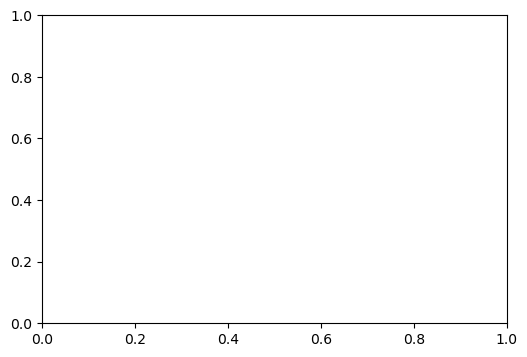

In [ ]:
plot_ctx = utils.PlotContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    device=device,
    patches=[],
    colour_map='inferno',
    vmin=0,
    vmax=4,
    N=100,
    x_label="Epochs",
    y_label="Loss",
)

utils.plot_loss_values({'curriculum loss': curriculum_loss_vals, 'Naive loss': naive_loss_vals}, plot_ctx)
utils.plot_loss_values({}, plot_ctx)

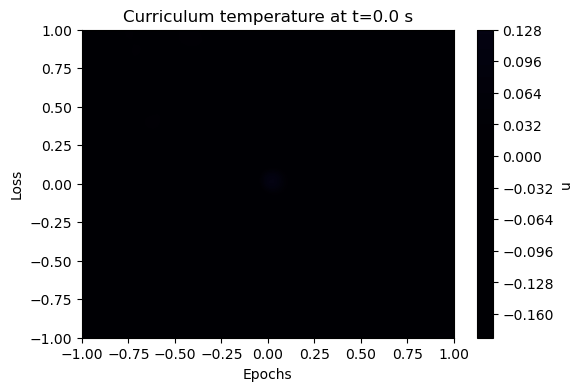

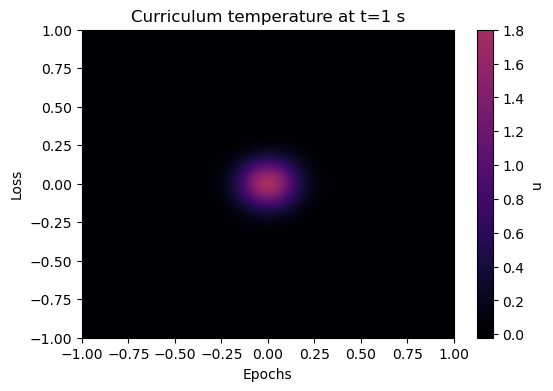

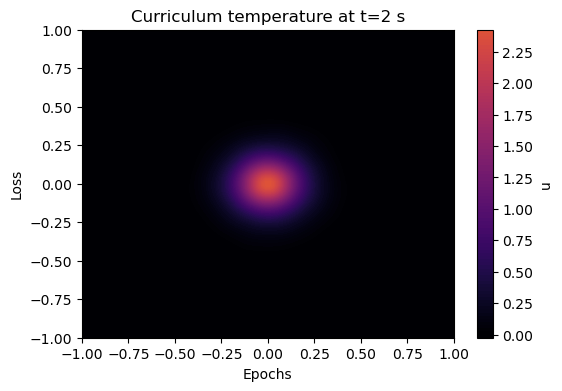

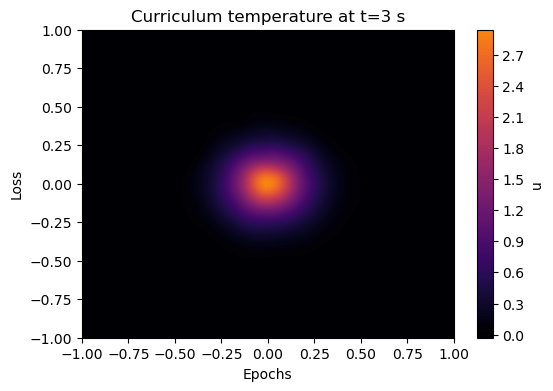

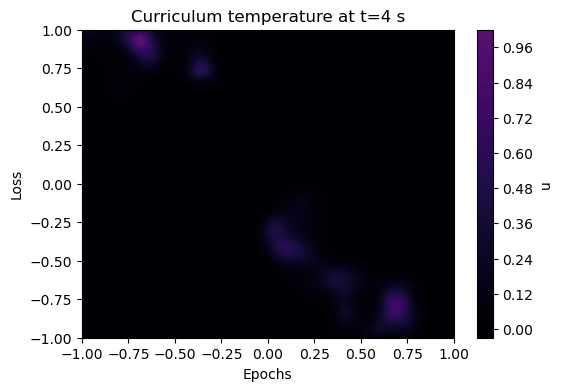

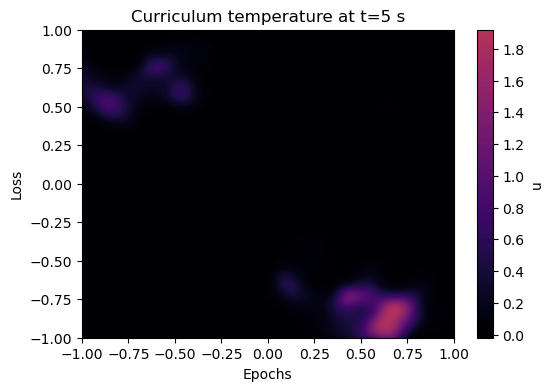

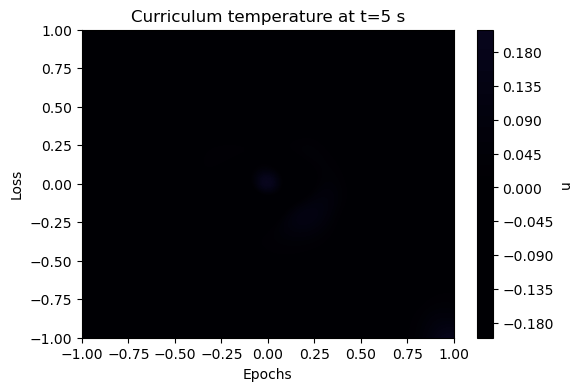

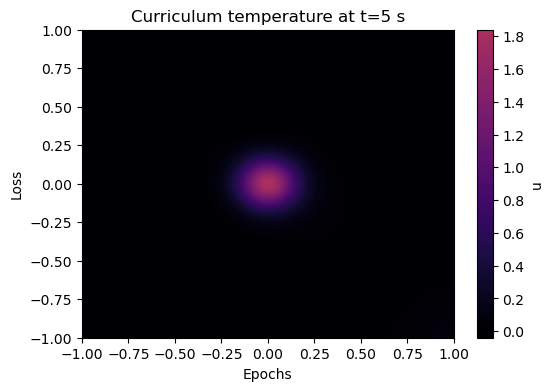

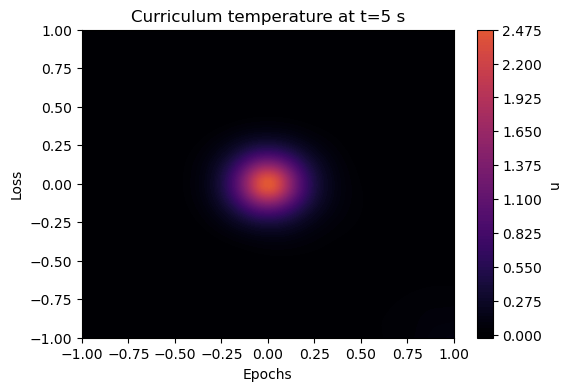

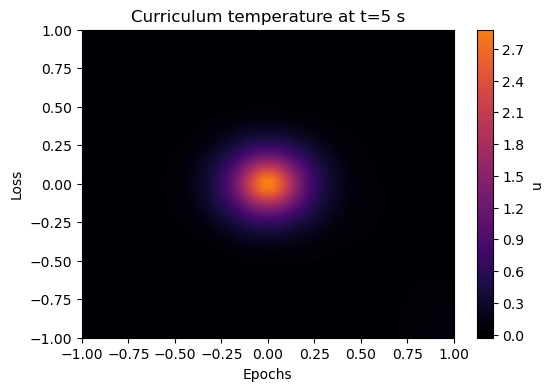

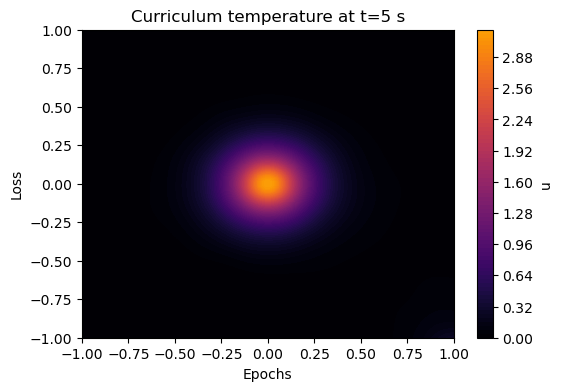

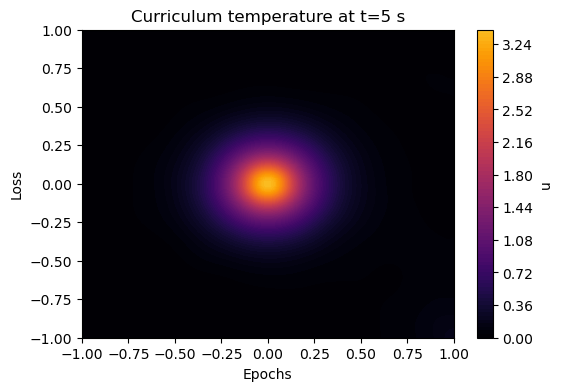

In [66]:
# vykresleni vysledku

TIME = 0

def s2s_u_t(input: torch.Tensor) -> torch.Tensor:
    time = torch.full_like(input[:, 0:1], TIME, device=device)
    return model_curriculum(torch.cat((input, time), dim=1))

def naive_u_t(input: torch.Tensor) -> torch.Tensor:
    time = torch.full_like(input[:, 0:1], TIME, device=device)
    return model_naive(torch.cat((input, time), dim=1))

plot_ctx.function_names = ['u']

for TIME in [0.0, 1, 2, 3, 4, 5]:
    plot_ctx.titles = [f"Curriculum temperature at t={TIME} s"]
    utils.plot_function_on_2d_cube([s2s_u_t], plot_ctx)

for TIME in [0.0, 1, 2, 3, 4, 5]:
    plot_ctx.title = f"Naive temperature at t={TIME} s"
    utils.plot_function_on_2d_cube([naive_u_t], plot_ctx)